In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import keras.backend as K
print(tf.__version__)

# Create a list with the filepaths for training and testing
train_dir = Path('custom_dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.jpeg')) 

test_dir = Path('custom_dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg'))
val_dir = Path('custom_dataset/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg')) 

def proc_img(filepath):
    """ Creating a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

2.11.0


In [56]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2200

Number of different labels: 22

Labels: ['french_fries' 'donuts' 'tomato' 'cauliflower' 'corn' 'cheese' 'omlette'
 'pineapple' 'apple' 'pizza' 'mango' 'burger' 'cabbage' 'chicken_curry'
 'grapes' 'samosa' 'soup' 'hot_dog' 'carrot' 'ice_cream' 'banana' 'momos']


In [57]:
train_df.head(5)

,Filepath,Label
0,custom_dataset\train\french_fries\57594.jpg,french_fries
1,custom_dataset\train\donuts\133593.jpg,donuts
2,custom_dataset\train\tomato\Image_1.jpg,tomato
3,custom_dataset\train\cauliflower\Image_31.jpg,cauliflower
4,custom_dataset\train\corn\Image_9 (2).jpg,corn


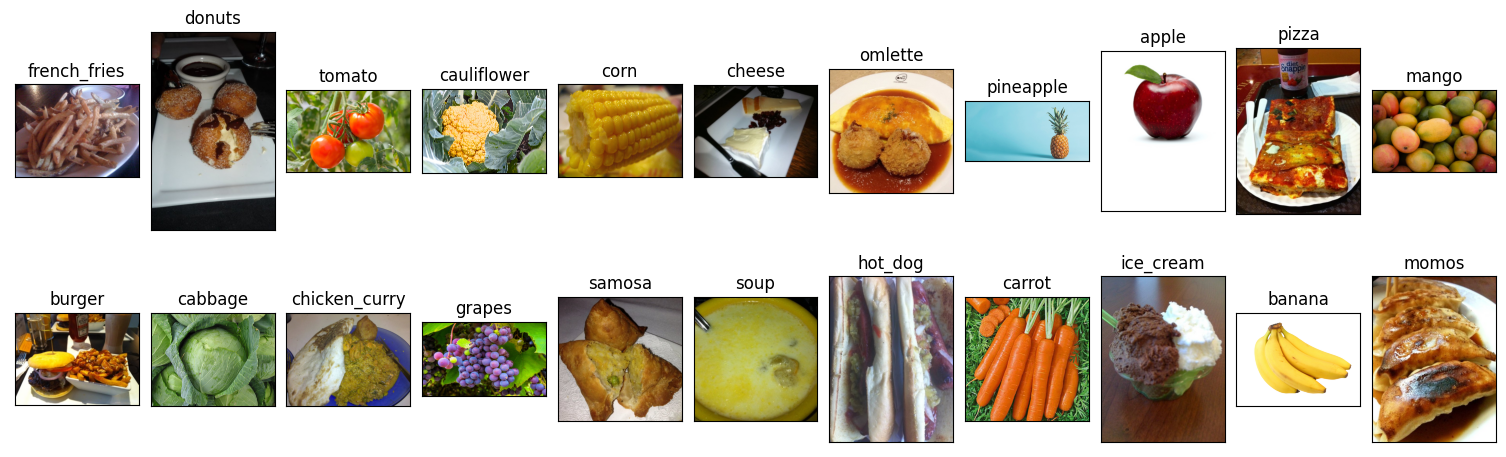

In [58]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [59]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2200 validated image filenames belonging to 22 classes.
Found 221 validated image filenames belonging to 22 classes.
Found 219 validated image filenames belonging to 22 classes.


In [60]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [61]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(22, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
16/69 [=====>........................] - ETA: 1:06 - loss: 2.9792 - accuracy: 0.1367

C:\Users\sandeep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 [==============================] - 98s 1s/step - loss: 1.9587 - accuracy: 0.4523 - val_loss: 0.6715 - val_accuracy: 0.8326
Epoch 2/10
69/69 [==============================] - 97s 1s/step - loss: 0.7969 - accuracy: 0.7682 - val_loss: 0.4286 - val_accuracy: 0.8914
Epoch 3/10
69/69 [==============================] - 111s 2s/step - loss: 0.5333 - accuracy: 0.8327 - val_loss: 0.3747 - val_accuracy: 0.8507
Epoch 4/10
69/69 [==============================] - 109s 2s/step - loss: 0.4206 - accuracy: 0.8755 - val_loss: 0.3659 - val_accuracy: 0.8778
Epoch 5/10
69/69 [==============================] - 115s 2s/step - loss: 0.3034 - accuracy: 0.9059 - val_loss: 0.4013 - val_accuracy: 0.8914
Epoch 6/10
69/69 [==============================] - 113s 2s/step - loss: 0.2301 - accuracy: 0.9359 - val_loss: 0.3670 - val_accuracy: 0.8869
Epoch 7/10
69/69 [==============================] - 138s 2s/step - loss: 0.1841 - accuracy: 0.9505 - val_loss: 0.3180 - val_accuracy: 0.9005
Epoch 8/10
69/69 [========

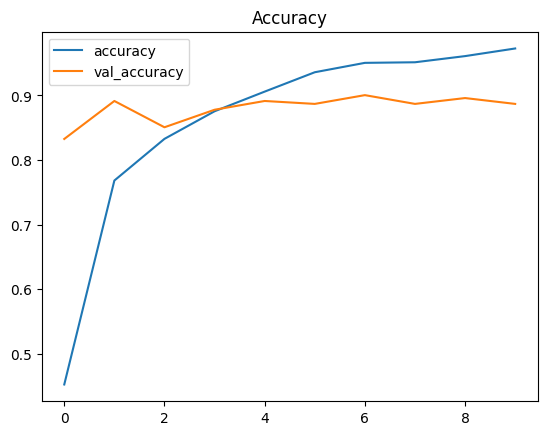

In [62]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

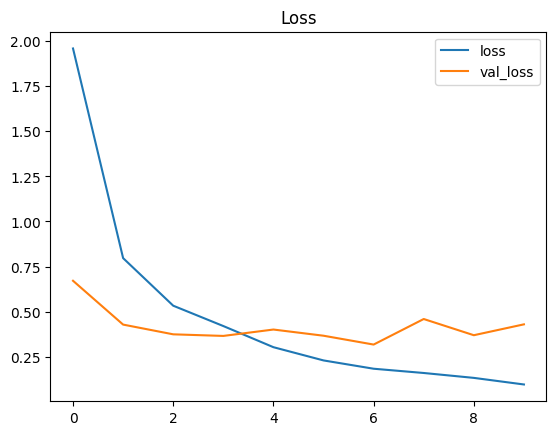

In [63]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [64]:
# Predict the Label of the testimages
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the Label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
pred1

7/7 [==============================] - 14s 2s/step


['momos',
 'banana',
 'omlette',
 'french_fries',
 'mango',
 'grapes',
 'grapes',
 'banana',
 'samosa',
 'grapes',
 'momos',
 'samosa',
 'tomato',
 'cheese',
 'ice_cream',
 'french_fries',
 'pizza',
 'apple',
 'apple',
 'momos',
 'grapes',
 'cabbage',
 'ice_cream',
 'corn',
 'carrot',
 'carrot',
 'donuts',
 'mango',
 'chicken_curry',
 'cheese',
 'samosa',
 'chicken_curry',
 'cabbage',
 'french_fries',
 'banana',
 'chicken_curry',
 'apple',
 'hot_dog',
 'grapes',
 'momos',
 'soup',
 'chicken_curry',
 'donuts',
 'cauliflower',
 'cauliflower',
 'hot_dog',
 'pizza',
 'carrot',
 'soup',
 'banana',
 'mango',
 'apple',
 'ice_cream',
 'donuts',
 'tomato',
 'ice_cream',
 'cauliflower',
 'grapes',
 'hot_dog',
 'carrot',
 'ice_cream',
 'momos',
 'momos',
 'omlette',
 'soup',
 'tomato',
 'cauliflower',
 'samosa',
 'corn',
 'pineapple',
 'burger',
 'grapes',
 'cheese',
 'french_fries',
 'burger',
 'cauliflower',
 'cheese',
 'apple',
 'french_fries',
 'banana',
 'tomato',
 'chicken_curry',
 'grapes'

In [65]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred1)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 91.78%


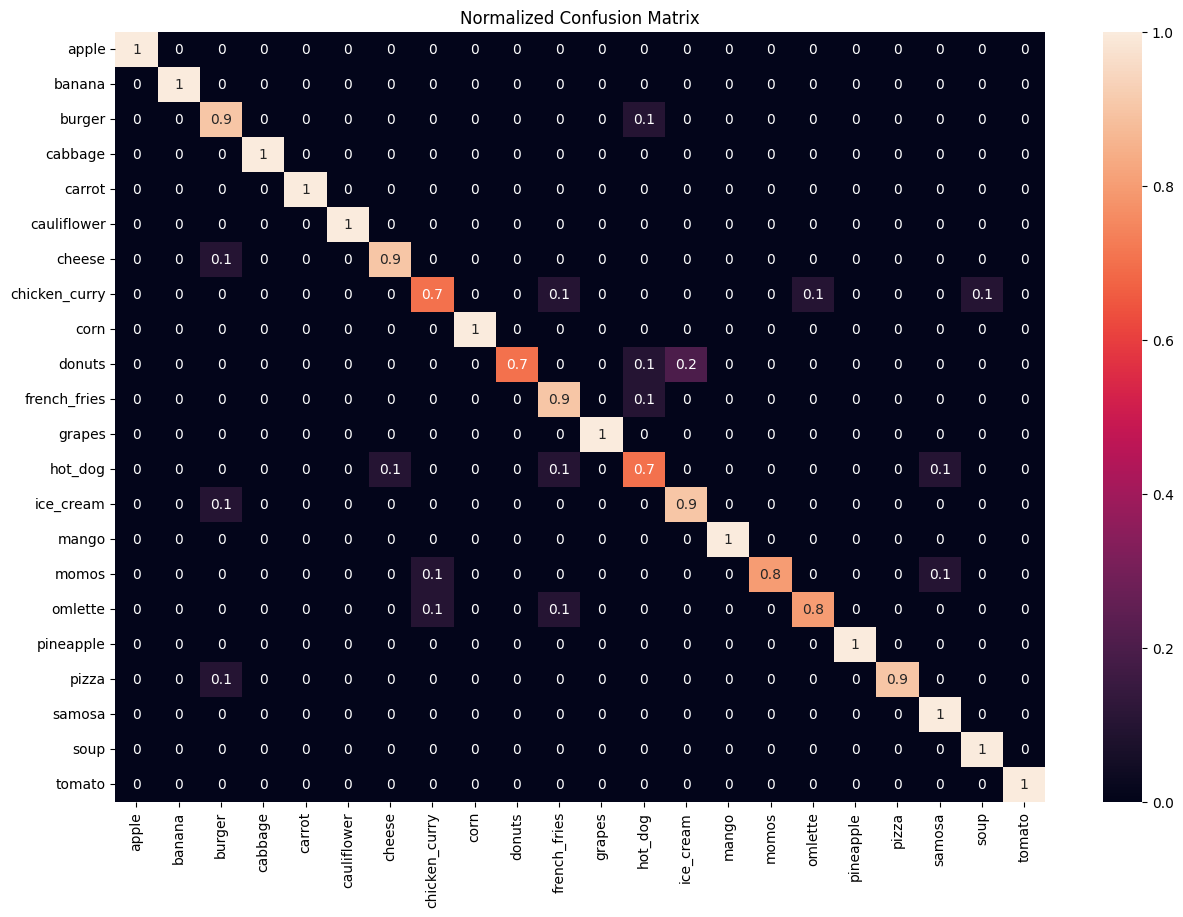

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,
                            y_pred=pred1))

               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      1.00      1.00        10
       burger       0.75      0.90      0.82        10
      cabbage       1.00      1.00      1.00        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
       cheese       0.90      0.90      0.90        10
chicken_curry       0.78      0.70      0.74        10
         corn       1.00      1.00      1.00        10
       donuts       1.00      0.70      0.82        10
 french_fries       0.75      0.90      0.82        10
       grapes       1.00      1.00      1.00        10
      hot_dog       0.70      0.70      0.70        10
    ice_cream       0.82      0.90      0.86        10
        mango       1.00      1.00      1.00        10
        momos       1.00      0.80      0.89        10
      omlette       0.89      0.80      0.84        10
    pinea

In [5]:
from tensorflow.keras.utils import load_img,img_to_array
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
#testing with an image

img = output(r'C:\Users\sandeep\Desktop\project\softcomputingJcomp\Food-Classification-main\custom_datasetv2\train\apple\aug__0_13.jpg')
img

In [70]:
model.save('FV.h5')